# Classe di backtesting

Crea una classe di backtesting, del tutto analoga a quella per SMA, che funzioni con il Momentum e Contrarian. Questa classe ha un solo parametro numerico (la finestra) e un parametro booleano (momentum o contrarian).

# Consideriamo anche il volume

Modifica la strategia Momentum/Contrarian:
- prendi in considerazione soltanto il rendimento del periodo precedente invece della media mobile
- prendi in considerazione il volume di scambio: soltanto se il volume di scambio del periodo precedente è maggiore del massimo degli N volumi precedenti, allora dai un segnale di acquisto (se rendimento positivo e strategia momentum  oppure se rendimento negativo e strategia contrarian) o di vendita. Se invece il volume non è abbastanza grande, il segnale sarà semplicemente 0, cioè usciamo da eventuali posizioni aperte e non facciamo nulla.

Verifica la strategia e trova il valore di N ottimale.

Opzionale: considera anche le spese di transazione.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn")
import tpqoa
api = tpqoa.tpqoa("oandaMY.cfg")

C:\Users\Paolo\AppData\Local\Temp\ipykernel_27564\1149040947.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [11]:
class MCBacktester():
    
    def __init__(self, symbol, window, MC, start, end):
        # MC True è momentum, False Contrarian
        self._symbol = symbol
        self._window = window
        self._MC = MC
        self._start = start
        self._end = end
        self._results = None
        self.get_data()
        self.prepare_data()
        
    def __repr__(self):
        return "MCBacktester(symbol = {}, window = {}, Momentum = {}, start = {}, end = {})".format(self._symbol,self._window,self._MC,self._start,self._end)
        
    def get_data(self): # carica i dati
        df = api.get_history(instrument = self._symbol, start = self._start, end = self._end, granularity = "H6", price = "B").dropna()
        df["logRet"]=np.log(df.c/df.c.shift(1))
        self.data=df
    
    def prepare_data(self): # contruisce il dataframe internamente 
        self.data["MV"]=self.data["volume"].shift(1).rolling(self._window).max()
        #return self.data
    
    def set_parameters(self, window=None, MC=None):
        if window is not None:
            self._window = window
            self.data["MV"]=self.data.volume.shift(1).rolling(window).max()
        if MC is not None:
            self._MC = MC

    def test_strategy(self):
        data=self.data.copy().dropna()
        if self._MC:
            data["posizione"] = np.where( data.volume < data.MV, 0 , 1  ) # momentum strategy
        else:
            data["posizione"] = np.where( data.volume < data.MV, 0 , -1  ) # contrarian strategy
            
        data["strategia"]= data.posizione.shift(1) * data.logRet
        data.dropna(inplace=True)
        data["cumLogRet"]= data.logRet.cumsum()
        data["cumStrategia"]= data.strategia.cumsum()
        # performance = np.exp(data.cumStrategia.iloc[-1])
        # outPerformance = performance - np.exp(data.cumLogRet.iloc[-1])
        performance = data.cumStrategia.iloc[-1]
        outPerformance = performance - data.cumLogRet.iloc[-1]
        maxDrawdown=(data.strategia.cumsum().cummax()-data.strategia.cumsum()).max()
        self._results=data
        return round(performance,6),round(outPerformance,6),round(maxDrawdown,6)
    
    def plot_results(self):
        if self._results is None:
            print("Devi prima chiamare test_strategy()")
        else:
            titolo="{}    window = {}     Momentum = {}".format(self._symbol,self._window,self._MC)
            self._results[["cumLogRet","cumStrategia"]].plot(figsize=(25,15))
            plt.legend(fontsize=18)
            plt.title(titolo,fontsize=22)
    
    def optimize_parameters(self, window_range): # ranges are tuples
        combinazioni = list(product(range(window_range[0],window_range[1]),[True,False] ))
        risultati= []
        for comb in combinazioni:
            self.set_parameters(comb[0],comb[1])
            risultati.append(self.test_strategy()[0])
        
        best_performance = np.max(risultati)
        best_combinazione = combinazioni[np.argmax(risultati)]
        
        # eseguiamo la strategia migliore
        self.set_parameters(best_combinazione[0],best_combinazione[1])
        self.test_strategy()
        
        # mettiamo i risulati in un bel dataframe
        AllResults = pd.DataFrame(combinazioni, columns=["window","Momentum"])
        AllResults["performance"]= risultati
        self.results_overview = AllResults
        
        return best_combinazione, best_performance

In [12]:
tester = MCBacktester("EUR_USD",5,False,"2021-10-01","2023-10-01")

In [13]:
tester.test_strategy()

(0.013275, 0.107021, 0.046158)

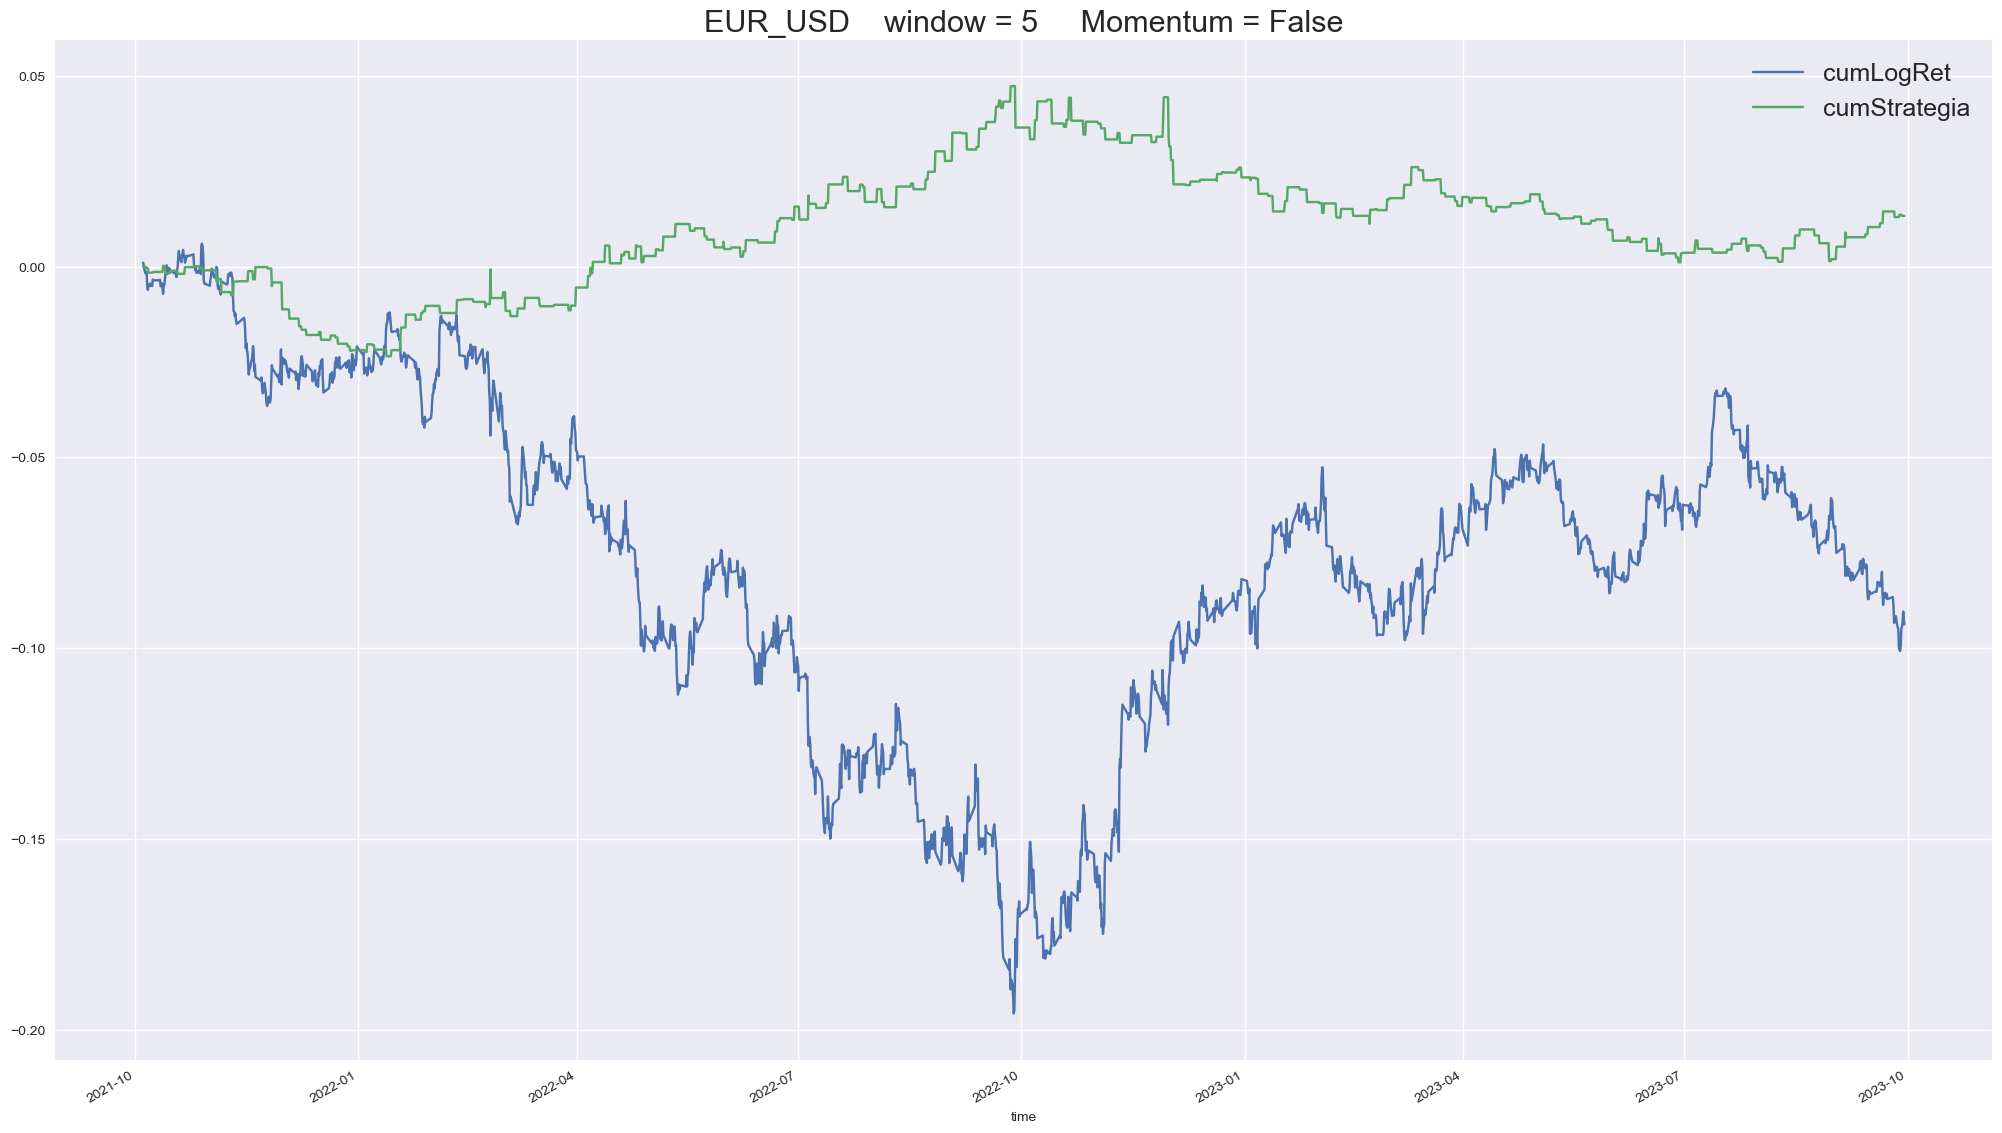

In [14]:
tester.plot_results()

In [15]:
tester.optimize_parameters((1,20))

((1, False), 0.098888)

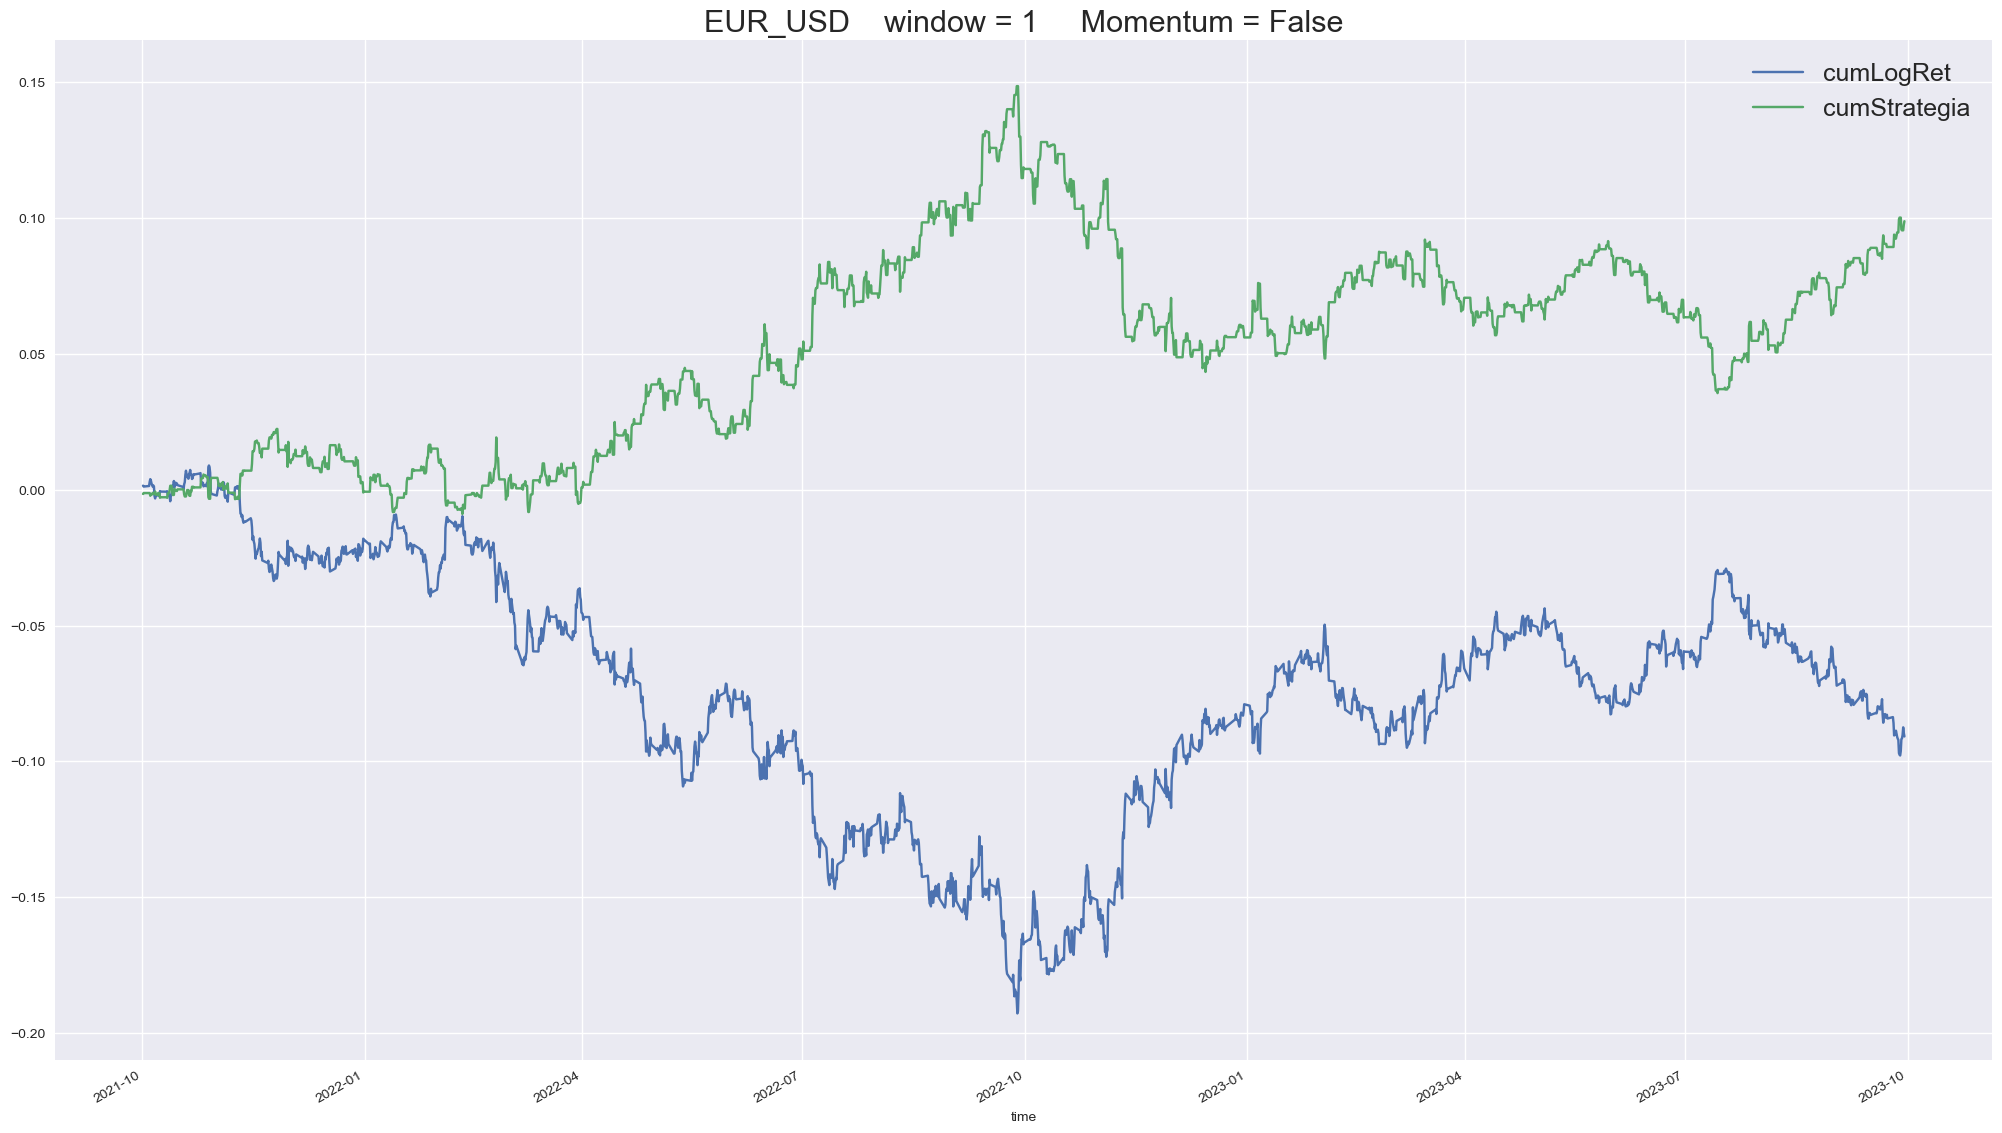

In [16]:
tester.plot_results()